# CISC 451/839 Topics in Data Analytics 
## Course Project - Using Feature Engineering and Supervised Learning to Predict Game Results in Professional Hockey 
### Gavin McClelland - 10211444 
### Marshall Cunningham - 20249991

TODO: Fix this description

The objectives of this notebook are as follows: 
- Build on top of the previous approaches included in the midterm submission which featured extensive EDA and simple model construction to justify the validity of the project (not trivial to understand game results if information about the score is omitted)
- Using performance trends from previous games, aim to develop models to predict the result of a game before it happens
    - we are only concerned with the binary classification task of predicting wins and losses, not the condition of victory (such as winning in regulation, overtime, or in a shootout)

## Contents

The analytics process contained in this notebook is as follows:

1. Read-in Data
2. Create features in the range [0,1]
3. Min-Max normalization
4. Feature selection


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix,roc_curve,auc
%cd "C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\project\data"
%matplotlib inline

C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\project\data


In [2]:
# Importing datasets, from the previous snapshot of work done for the midterm submission, and more sophisticated information from moneypuck.com 
# teams = pd.read_csv("teamstats_midterm.csv")
# adv_stats = pd.read_csv("moneypuck_teamstats2017-2018.csv")
# game_stats = pd.read_csv("moneypuck_allgames2017.csv")
game_stats = pd.read_csv("10seasons.csv")
team_stats = pd.read_csv('game_teams_stats.csv')

In [3]:
team_stats.drop(team_stats[team_stats.game_id > 2018000000].index, inplace=True)
team_stats = team_stats[['game_id', 'HoA', 'won']]
team_stats.rename(
    columns={
        "game_id": "gameId",
        "HoA": "home_or_away",
        "won": "WON"
    }, inplace=True
)
team_stats['home_or_away'] = team_stats['home_or_away'].str.upper()

game_stats = pd.merge(game_stats, team_stats,how='inner',on=['gameId','home_or_away'])

# Taking the result label from the team stats dataset
game_stats['WON'] = np.where(game_stats['WON'] == True, 1, 0)
game_stats.groupby('WON').count()

,team,season,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,situation,...,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame
WON,,,,,,,,,,,,,,,,,,,,,
0,9381,9381,9381,9381,9381,9381,9381,9381,9381,9381,...,9381,9381,9381,9381,9381,9381,9381,9381,9381,9381
1,9361,9361,9361,9361,9361,9361,9361,9361,9361,9361,...,9361,9361,9361,9361,9361,9361,9361,9361,9361,9361


In [4]:
game_stats.drop(columns=['season',
                        'name',
                        'playerTeam',
                        'opposingTeam',
                        'gameDate',
                        'position',
                        'situation',
                        'iceTime',
                        'playoffGame'], inplace=True)                     
game_stats.head()

,team,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,...,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,WON
0,TOR,2010020001,HOME,0.3191,0.4538,0.4342,23.965,1.469,1.480,5.820,...,43,42.078,5,0.562,0.806,0.806,2.891,2.899,2.774,1
1,MTL,2010020001,AWAY,0.6809,0.5462,0.5658,32.814,3.135,2.419,6.379,...,33,33.962,12,0.309,0.000,0.000,1.778,1.772,1.758,0
2,PIT,2010020002,HOME,0.4835,0.5603,0.5698,34.905,3.173,2.536,7.994,...,37,39.188,7,0.389,0.410,0.410,3.369,3.482,3.452,0
3,PHI,2010020002,AWAY,0.5165,0.4397,0.4302,26.012,3.390,1.782,5.868,...,49,46.974,3,0.552,0.318,0.318,3.406,3.287,3.225,1
4,MIN,2010020003,HOME,0.4120,0.4870,0.4805,28.668,2.644,2.152,6.873,...,40,42.408,5,0.428,0.908,0.908,3.292,3.472,3.391,0


In [5]:
# most features have a 'for' and 'against' pair, so we will combine them into a ratio in the range 0:1, which adds additional context to the game (i.e. which team had more shots on goal, etc.)
entries = []
for column in game_stats.columns.tolist():
    if column[-3:] == 'For':
        entries.append(column[:-3])
# NOTE: This took awhile to figure out, but if the stat has '0' in the for AND against columns, then the ratio will be null. If this is the case, we assign a ratio of 0.5 to each team with that gameId which provides a neutral, non-zero weight
for x in entries:
    game_stats[f'{x}Ratio'] = game_stats.apply(lambda row: row[f'{x}For'] / (row[f'{x}For'] + row[f'{x}Against']) if (row[f'{x}For'] + row[f'{x}Against']) != 0 else 0.5, axis=1)
    game_stats.drop(columns=[f'{x}For',f'{x}Against'],inplace=True)

In [6]:
# creating the result label from the goalsRatio feature, basically, the game is won if more goals are scored than conceded--simple enough
game_stats['WON'] = np.where(game_stats['goalsRatio']>=0.5, 1, 0)

In [7]:
# note that many of the probabalistic statistics (such as xGoalsPercentage) are not always a direct indicator of success. Teams with an xGoalsPercentage less than 50% still win games (roughly 20%)
game_stats.loc[(game_stats.xGoalsPercentage < 0.5) & (game_stats.WON == 1)].shape[0]

3969

In [8]:
cols_to_normalize = game_stats.drop(columns=['team','gameId','home_or_away','WON']).columns.tolist()
# Min-Max Normalization
for column in cols_to_normalize:
        game_stats[column] = (game_stats[column] - game_stats[column].min()) / (game_stats[column].max() - game_stats[column].min())
game_stats

,team,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,WON,xOnGoalRatio,xGoalsRatio,xReboundsRatio,...,scoreAdjustedShotsAttemptsRatio,unblockedShotAttemptsRatio,scoreAdjustedUnblockedShotAttemptsRatio,dZoneGiveawaysRatio,xGoalsFromxReboundsOfShotsRatio,xGoalsFromActualReboundsOfShotsRatio,reboundxGoalsRatio,totalShotCreditRatio,scoreAdjustedTotalShotCreditRatio,scoreFlurryAdjustedTotalShotCreditRatio
0,TOR,2010020001,HOME,0.282520,0.421026,0.384073,1,0.363208,0.282488,0.310877,...,0.433891,0.384085,0.409142,0.705882,0.268453,0.000000,0.000000,0.342626,0.340433,0.351453
1,MTL,2010020001,AWAY,0.717480,0.578974,0.615927,0,0.636792,0.717512,0.689123,...,0.566109,0.615915,0.590858,0.294118,0.731547,1.000000,1.000000,0.657374,0.659567,0.648547
2,PIT,2010020002,HOME,0.480164,0.603077,0.622974,0,0.628134,0.480125,0.637126,...,0.558438,0.622924,0.576924,0.300000,0.638081,0.436813,0.436813,0.503605,0.480948,0.477473
3,PHI,2010020002,AWAY,0.519836,0.396923,0.377026,1,0.371866,0.519875,0.362874,...,0.441562,0.377076,0.423076,0.700000,0.361919,0.563187,0.563187,0.496395,0.519052,0.522527
4,MIN,2010020003,HOME,0.394205,0.477778,0.465645,0,0.470044,0.394244,0.537067,...,0.437429,0.465677,0.429371,0.500000,0.549767,0.190731,0.190731,0.459902,0.432858,0.433567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18737,VAN,2017021269,AWAY,0.526809,0.525470,0.525722,1,0.534239,0.526764,0.470607,...,0.547047,0.525659,0.544862,0.529412,0.489789,0.470156,0.470156,0.533316,0.556175,0.564338
18738,DAL,2017021270,AWAY,0.574657,0.221026,0.238196,1,0.246140,0.574682,0.356214,...,0.310713,0.238095,0.334534,0.461538,0.363252,0.777622,0.777622,0.441858,0.504536,0.496929
18739,L.A,2017021270,HOME,0.425343,0.778974,0.761804,0,0.753860,0.425318,0.643786,...,0.689287,0.761905,0.665466,0.538462,0.636748,0.222378,0.222378,0.558142,0.495464,0.503071
18740,MIN,2017021271,AWAY,0.577783,0.397436,0.323820,1,0.352376,0.577728,0.386562,...,0.465282,0.323810,0.392685,0.888889,0.371621,0.000000,0.000000,0.578462,0.621175,0.622651


In [9]:
# rearranging columns to beginning of df for organization purposes
cols = game_stats.drop(columns=['WON']).columns.tolist()
cols = ['WON'] + cols
game_stats = game_stats.reindex(columns=cols)
game_stats.head()

,WON,team,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalRatio,xGoalsRatio,xReboundsRatio,...,scoreAdjustedShotsAttemptsRatio,unblockedShotAttemptsRatio,scoreAdjustedUnblockedShotAttemptsRatio,dZoneGiveawaysRatio,xGoalsFromxReboundsOfShotsRatio,xGoalsFromActualReboundsOfShotsRatio,reboundxGoalsRatio,totalShotCreditRatio,scoreAdjustedTotalShotCreditRatio,scoreFlurryAdjustedTotalShotCreditRatio
0,1,TOR,2010020001,HOME,0.282520,0.421026,0.384073,0.363208,0.282488,0.310877,...,0.433891,0.384085,0.409142,0.705882,0.268453,0.000000,0.000000,0.342626,0.340433,0.351453
1,0,MTL,2010020001,AWAY,0.717480,0.578974,0.615927,0.636792,0.717512,0.689123,...,0.566109,0.615915,0.590858,0.294118,0.731547,1.000000,1.000000,0.657374,0.659567,0.648547
2,0,PIT,2010020002,HOME,0.480164,0.603077,0.622974,0.628134,0.480125,0.637126,...,0.558438,0.622924,0.576924,0.300000,0.638081,0.436813,0.436813,0.503605,0.480948,0.477473
3,1,PHI,2010020002,AWAY,0.519836,0.396923,0.377026,0.371866,0.519875,0.362874,...,0.441562,0.377076,0.423076,0.700000,0.361919,0.563187,0.563187,0.496395,0.519052,0.522527
4,0,MIN,2010020003,HOME,0.394205,0.477778,0.465645,0.470044,0.394244,0.537067,...,0.437429,0.465677,0.429371,0.500000,0.549767,0.190731,0.190731,0.459902,0.432858,0.433567


### Feature Selection
We already have quite a few features (55), so before looking at previous games to predict the result of a game before it happens, let's find out which of these features are of any significance

In [10]:
gs_cpy = game_stats
game_stats.columns.tolist()

['WON',
 'team',
 'gameId',
 'home_or_away',
 'xGoalsPercentage',
 'corsiPercentage',
 'fenwickPercentage',
 'xOnGoalRatio',
 'xGoalsRatio',
 'xReboundsRatio',
 'xFreezeRatio',
 'xPlayStoppedRatio',
 'xPlayContinuedInZoneRatio',
 'xPlayContinuedOutsideZoneRatio',
 'flurryAdjustedxGoalsRatio',
 'scoreVenueAdjustedxGoalsRatio',
 'flurryScoreVenueAdjustedxGoalsRatio',
 'shotsOnGoalRatio',
 'missedShotsRatio',
 'blockedShotAttemptsRatio',
 'shotAttemptsRatio',
 'goalsRatio',
 'reboundsRatio',
 'reboundGoalsRatio',
 'freezeRatio',
 'playStoppedRatio',
 'playContinuedInZoneRatio',
 'playContinuedOutsideZoneRatio',
 'savedShotsOnGoalRatio',
 'savedUnblockedShotAttemptsRatio',
 'penaltiesRatio',
 'penalityMinutesRatio',
 'faceOffsWonRatio',
 'hitsRatio',
 'takeawaysRatio',
 'giveawaysRatio',
 'lowDangerShotsRatio',
 'mediumDangerShotsRatio',
 'highDangerShotsRatio',
 'lowDangerxGoalsRatio',
 'mediumDangerxGoalsRatio',
 'highDangerxGoalsRatio',
 'lowDangerGoalsRatio',
 'mediumDangerGoalsRatio',

Fitting a simple logistic regression model to our features to resolve feature "importances"

In [11]:
# Dropping categorical features, and also dropping goalsRatio, which explicitly represents the goals scored by each team
X = game_stats.drop(columns=['team','gameId','home_or_away','goalsRatio','WON']) 
Y = game_stats['WON']

In [12]:
lr = LogisticRegression()
lr.fit(X,Y)

LogisticRegression()

In [13]:
np.abs(lr.coef_[0])

array([3.37685235e-02, 1.77801586e-01, 3.35837626e+00, 1.48735323e+00,
       3.38888981e-02, 2.62422129e+00, 2.69037744e+00, 3.26632486e-01,
       1.58152376e+00, 5.26260030e+00, 2.81885425e+00, 9.01993585e-02,
       2.66306180e+00, 8.96950985e+00, 3.34834678e+00, 3.59123492e+00,
       1.77090444e-01, 5.19423417e-01, 9.96426916e-01, 3.03117785e+00,
       5.45328991e-01, 6.55097111e+00, 5.68604254e+00, 1.54059803e+01,
       1.40428119e+01, 4.67209399e-01, 7.09466596e-01, 4.75508436e-01,
       3.21842084e-03, 1.38207208e+00, 1.98325011e-01, 3.39156372e-03,
       6.65895376e-01, 7.57222225e-01, 1.03976975e-01, 2.61514338e+00,
       1.90338969e+00, 4.70803096e+00, 4.66100816e+00, 3.50961479e+00,
       4.81209666e+00, 3.36026625e+00, 7.32249451e+00, 2.74351146e-01,
       4.20094331e+00, 2.88983759e-01, 1.64638202e-01, 1.46320925e+00,
       1.31581228e+00, 3.63180977e+00])

Below, we plot our feature coefficients in descending order to observe where a drop-off occurs

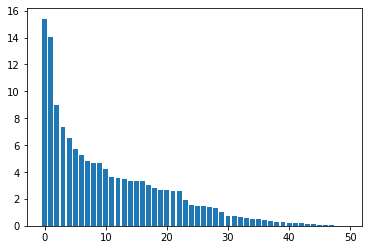

In [14]:
importance = np.abs(lr.coef_[0])
sorted_importance = -np.sort(-importance)
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(sorted_importance))], sorted_importance)
plt.show()

From the plot above, we are choosing the top 19 features as there is an observable drop-off in performance afterwards

Next, we find our columns to drop from our dataset, so we are left with our 19 most important features

In [15]:
cols_to_drop = []
thresh = sorted_importance[18]
for n,val in enumerate(importance):
    print(val)
    if val < thresh:
        cols_to_drop.append(game_stats.columns[n+4])
game_stats.drop(cols_to_drop,axis=1,inplace=True)

0.033768523494898804
0.1778015855605586
3.3583762588804715
1.4873532287662279
0.03388889805170358
2.624221287541249
2.690377444206607
0.3266324859426543
1.581523756909442
5.262600295569326
2.8188542470759548
0.09019935852589969
2.6630617953924283
8.969509846261866
3.3483467820040387
3.59123491787268
0.17709044412482985
0.5194234168106902
0.9964269158039754
3.0311778457989935
0.5453289909145992
6.5509711098860315
5.686042536888863
15.405980315411043
14.04281186381319
0.4672093993012037
0.7094665957850489
0.4755084357736164
0.0032184208404174674
1.3820720812019516
0.19832501054165985
0.00339156371987229
0.6658953764701854
0.7572222250835636
0.1039769751999089
2.6151433820854244
1.9033896877504055
4.708030959566643
4.661008161642136
3.509614788283832
4.812096662706458
3.3602662539090504
7.322494511512256
0.2743511455652452
4.200943309451717
0.2889837588840419
0.1646382022058289
1.4632092502119187
1.3158122767989562
3.631809772536812


In [16]:
# Verifying that feature selection worked as expected
print(cols_to_drop)

['xGoalsPercentage', 'corsiPercentage', 'xOnGoalRatio', 'xGoalsRatio', 'xReboundsRatio', 'xFreezeRatio', 'xPlayStoppedRatio', 'xPlayContinuedInZoneRatio', 'scoreVenueAdjustedxGoalsRatio', 'flurryScoreVenueAdjustedxGoalsRatio', 'shotAttemptsRatio', 'goalsRatio', 'reboundsRatio', 'freezeRatio', 'savedUnblockedShotAttemptsRatio', 'penaltiesRatio', 'penalityMinutesRatio', 'faceOffsWonRatio', 'hitsRatio', 'takeawaysRatio', 'giveawaysRatio', 'lowDangerShotsRatio', 'mediumDangerShotsRatio', 'highDangerShotsRatio', 'lowDangerxGoalsRatio', 'mediumDangerxGoalsRatio', 'scoreAdjustedUnblockedShotAttemptsRatio', 'xGoalsFromxReboundsOfShotsRatio', 'xGoalsFromActualReboundsOfShotsRatio', 'reboundxGoalsRatio', 'totalShotCreditRatio']


Next, we create a correlation heatmap to visualize any redundant/synonymous features, along with those that are too highly correlated with the outcome label 'WON'

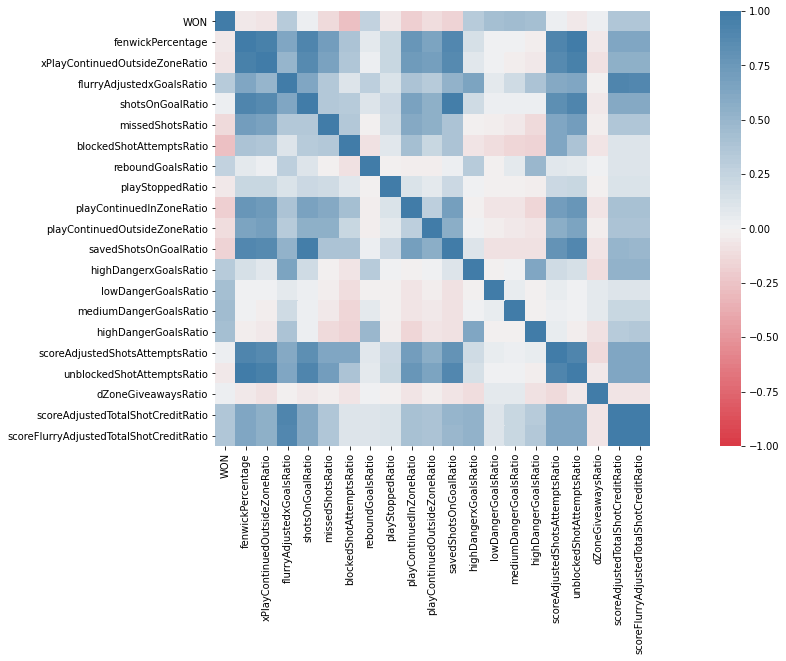

In [17]:
corr = game_stats.drop(columns=['team','gameId','home_or_away']).corr()
fig, ax = plt.subplots(figsize=(25,8)) 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1,
    square=True,
    cmap=sns.diverging_palette(10,240,n=100),
    ax=ax
)

The only duplicate features are different versions of the same stat, which can be seen near the bottom (different versions of shotCredit)
- So, we keep the flurry adjusted stat as flurry is more repeatable and regarded as having more predictive power (see report)

In [19]:
game_stats.drop(columns=['scoreAdjustedTotalShotCreditRatio'],inplace=True)

In [20]:
# dimensions of the dataset after selecting features
game_stats.shape

(18742, 23)

In [21]:
feat = game_stats.drop(columns=['team','home_or_away','gameId','WON'])
label = game_stats['WON']

x_train,x_test,y_train,y_test = train_test_split(feat,label,test_size=0.3) # test on 30% of dataset 
lr2 = LogisticRegression()
lr2.fit(x_train,y_train)
pred = lr2.predict(x_test)
accuracy_score(y_test,pred)

0.9171260892761871

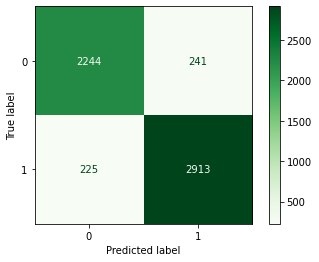

In [22]:
plot_confusion_matrix(lr2,x_test,y_test,cmap=plt.cm.Greens)

## Creating Historical Features
With the objective of predicting outcome before a game has occurred, it is important to have information about the team /before/ the game takes place
- So, below we create rolling averages from the previous 1, 3, and 5 games not including the current game. This will create historical versions of the previously selected features for training our model

In [21]:
window_lengths = (1, 3, 5)
new_cols = ['team','home_or_away','gameId']

for col in game_stats.columns:
    if col in new_cols:
        continue
    if col == 'WON':
        new_cols.append(col)
    for length in window_lengths:
        new_cols.append(f'{col}Prev{length}')
new_df = pd.DataFrame(columns=new_cols)
for team in game_stats.team.sort_values(ascending=True).unique().tolist():
    # print(team)
    df = game_stats.loc[game_stats['team'] == team]
    # print(df)
    df.sort_values('gameId', ascending=True, inplace=True)
    for col in df.columns:
        if col != 'WON' and col in new_cols:
            continue
        for length in window_lengths:
            df[f'{col}Prev{length}'] = df[col].rolling(length).mean().shift(1)
        if col != 'WON':
            df.drop(col, axis=1, inplace=True)
    new_df = pd.concat([new_df, df])
# new_df.sort_values('gameId', ascending=True, inplace=True)

In [22]:
new_df.shape

(2542, 61)

In [23]:
# We need to handle NaN's here by dropping the first five games each team plays so the historical features can take effect
new_df.dropna(inplace=True)

In [24]:
new_df

,team,home_or_away,gameId,WON,WONPrev1,WONPrev3,WONPrev5,xPlayContinuedOutsideZoneRatioPrev1,xPlayContinuedOutsideZoneRatioPrev3,xPlayContinuedOutsideZoneRatioPrev5,...,highDangerGoalsRatioPrev5,unblockedShotAttemptsRatioPrev1,unblockedShotAttemptsRatioPrev3,unblockedShotAttemptsRatioPrev5,dZoneGiveawaysRatioPrev1,dZoneGiveawaysRatioPrev3,dZoneGiveawaysRatioPrev5,scoreFlurryAdjustedTotalShotCreditRatioPrev1,scoreFlurryAdjustedTotalShotCreditRatioPrev3,scoreFlurryAdjustedTotalShotCreditRatioPrev5
154,ANA,HOME,2017020078,0,0.0,0.333333,0.4,0.214070,0.395384,0.458692,...,0.166667,0.123011,0.404294,0.457629,0.500000,0.479167,0.519246,0.013315,0.327568,0.386736
216,ANA,HOME,2017020109,1,0.0,0.333333,0.2,0.507429,0.355680,0.430088,...,0.100000,0.513951,0.355829,0.427998,0.750000,0.562500,0.580357,0.392254,0.309231,0.352070
253,ANA,AWAY,2017020127,1,1.0,0.333333,0.4,0.415894,0.379131,0.421895,...,0.100000,0.367127,0.334696,0.418792,0.437500,0.562500,0.525000,0.471880,0.292483,0.369368
288,ANA,AWAY,2017020145,0,1.0,0.666667,0.6,0.335089,0.419471,0.363605,...,0.300000,0.292173,0.391083,0.345357,0.538462,0.575321,0.532692,0.322273,0.395469,0.344369
317,ANA,AWAY,2017020159,1,0.0,0.666667,0.4,0.774531,0.508505,0.449402,...,0.350000,0.755639,0.471646,0.410380,0.454545,0.476836,0.536101,0.458451,0.417534,0.331635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2402,WSH,HOME,2017021202,0,1.0,1.000000,1.0,0.524018,0.517503,0.482750,...,0.500000,0.452739,0.480390,0.454754,0.428571,0.356532,0.403919,0.427122,0.609969,0.573253
2441,WSH,AWAY,2017021221,1,0.0,0.666667,0.8,0.508618,0.496607,0.477897,...,0.500000,0.469529,0.433222,0.442722,0.777778,0.504681,0.449475,0.358352,0.436689,0.541765
2451,WSH,AWAY,2017021226,1,1.0,0.666667,0.8,0.619238,0.550625,0.536073,...,0.400000,0.513010,0.478426,0.484742,0.375000,0.527116,0.444475,0.635212,0.473562,0.564694
2486,WSH,HOME,2017021244,0,1.0,0.666667,0.8,0.486336,0.538064,0.519079,...,0.400000,0.394737,0.459092,0.441483,0.625000,0.592593,0.502808,0.633734,0.542433,0.515803


## Let's Train Some Models
Creating a simple Logistic Regression model with our enriched dataset

In [25]:
cols_to_normalize = new_df.drop(columns=['team','gameId','home_or_away','WON']).columns.tolist()
# Min-Max Normalization
for column in cols_to_normalize:
    new_df[column] = (new_df[column] - new_df[column].min()) / (new_df[column].max() - new_df[column].min())

In [26]:
new_df

,team,home_or_away,gameId,WON,WONPrev1,WONPrev3,WONPrev5,xPlayContinuedOutsideZoneRatioPrev1,xPlayContinuedOutsideZoneRatioPrev3,xPlayContinuedOutsideZoneRatioPrev5,...,highDangerGoalsRatioPrev5,unblockedShotAttemptsRatioPrev1,unblockedShotAttemptsRatioPrev3,unblockedShotAttemptsRatioPrev5,dZoneGiveawaysRatioPrev1,dZoneGiveawaysRatioPrev3,dZoneGiveawaysRatioPrev5,scoreFlurryAdjustedTotalShotCreditRatioPrev1,scoreFlurryAdjustedTotalShotCreditRatioPrev3,scoreFlurryAdjustedTotalShotCreditRatioPrev5
154,ANA,HOME,2017020078,0,0.0,0.333333,0.4,0.214070,0.334202,0.440920,...,0.173611,0.112601,0.377389,0.440306,0.500000,0.388587,0.485401,0.013315,0.209911,0.252067
216,ANA,HOME,2017020109,1,0.0,0.333333,0.2,0.507429,0.271230,0.383561,...,0.104167,0.508181,0.305847,0.388137,0.750000,0.486413,0.575918,0.392254,0.181532,0.187481
253,ANA,AWAY,2017020127,1,1.0,0.333333,0.4,0.415894,0.308423,0.367132,...,0.104167,0.359614,0.274651,0.371929,0.437500,0.486413,0.493923,0.471880,0.155614,0.219708
288,ANA,AWAY,2017020145,0,1.0,0.666667,0.6,0.335089,0.372404,0.250243,...,0.312500,0.283771,0.357889,0.242640,0.538462,0.501463,0.505317,0.322273,0.314994,0.173133
317,ANA,AWAY,2017020159,1,0.0,0.666667,0.4,0.774531,0.513616,0.422293,...,0.364583,0.752738,0.476814,0.357119,0.454545,0.385851,0.510367,0.458451,0.349142,0.149407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2402,WSH,HOME,2017021202,0,1.0,1.000000,1.0,0.524018,0.527889,0.489164,...,0.520833,0.446243,0.489721,0.435244,0.428571,0.244625,0.314579,0.427122,0.646952,0.599570
2441,WSH,AWAY,2017021221,1,0.0,0.666667,0.8,0.508618,0.494746,0.479433,...,0.520833,0.463232,0.420094,0.414061,0.777778,0.418538,0.382056,0.358352,0.378786,0.540904
2451,WSH,AWAY,2017021226,1,1.0,0.666667,0.8,0.619238,0.580421,0.596094,...,0.416667,0.507229,0.486823,0.488041,0.375000,0.444876,0.374650,0.635212,0.435850,0.583623
2486,WSH,HOME,2017021244,0,1.0,0.666667,0.8,0.486336,0.560499,0.562015,...,0.416667,0.387552,0.458282,0.411879,0.625000,0.521739,0.461053,0.633734,0.542434,0.492533


In [27]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
feat = new_df.drop(columns=['team','home_or_away','gameId','WON'])
label = new_df['WON']

lr2 = LogisticRegression()
scores = cross_val_score(lr2, feat, label, cv=50)
print(scores)

x_train,x_test,y_train,y_test = train_test_split(feat,label,test_size=0.2) # test on 30% of dataset 
y_train = y_train.astype('int')
y_test = y_test.astype('int')
lr2.fit(x_train,y_train)
pred = lr2.predict(x_test)
print(accuracy_score(y_test,pred))

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
0.50418410041841


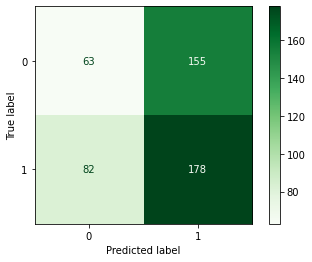

In [28]:
plot_confusion_matrix(lr2,x_test,y_test,cmap=plt.cm.Greens)

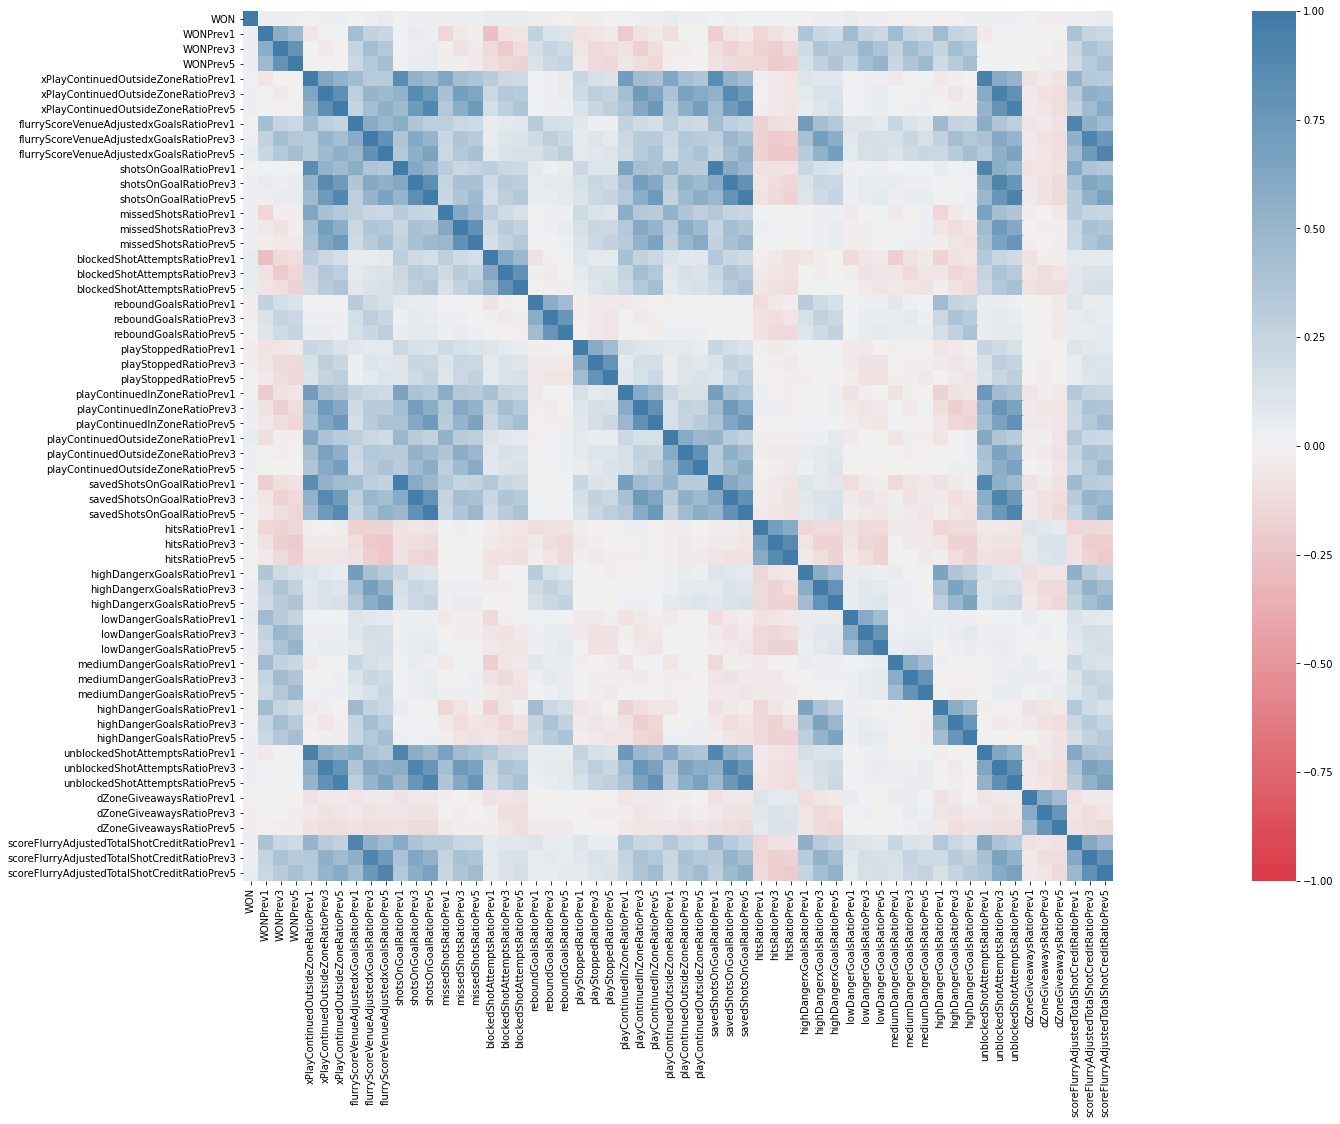

In [29]:
new_df.WON = new_df.WON.astype(int)
corr = new_df.drop(columns=['team','gameId','home_or_away']).corr()
fig, ax = plt.subplots(figsize=(50,16)) 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1,
    square=True,
    cmap=sns.diverging_palette(10,240,n=100),
    ax=ax
)

In [30]:
corr.WON.sort_values(ascending=False)

WON                                             1.000000
playContinuedOutsideZoneRatioPrev1              0.054337
scoreFlurryAdjustedTotalShotCreditRatioPrev5    0.052837
flurryScoreVenueAdjustedxGoalsRatioPrev5        0.049275
lowDangerGoalsRatioPrev1                        0.040945
blockedShotAttemptsRatioPrev5                   0.040865
blockedShotAttemptsRatioPrev3                   0.040457
blockedShotAttemptsRatioPrev1                   0.040343
missedShotsRatioPrev5                           0.039347
scoreFlurryAdjustedTotalShotCreditRatioPrev3    0.038468
playContinuedOutsideZoneRatioPrev3              0.037478
highDangerxGoalsRatioPrev5                      0.035730
playContinuedOutsideZoneRatioPrev5              0.035437
playContinuedInZoneRatioPrev5                   0.035296
unblockedShotAttemptsRatioPrev5                 0.034586
unblockedShotAttemptsRatioPrev3                 0.034051
flurryScoreVenueAdjustedxGoalsRatioPrev3        0.033252
xPlayContinuedOutsideZoneRatioP

In [31]:
corr.describe()

,WON,WONPrev1,WONPrev3,WONPrev5,xPlayContinuedOutsideZoneRatioPrev1,xPlayContinuedOutsideZoneRatioPrev3,xPlayContinuedOutsideZoneRatioPrev5,flurryScoreVenueAdjustedxGoalsRatioPrev1,flurryScoreVenueAdjustedxGoalsRatioPrev3,flurryScoreVenueAdjustedxGoalsRatioPrev5,...,highDangerGoalsRatioPrev5,unblockedShotAttemptsRatioPrev1,unblockedShotAttemptsRatioPrev3,unblockedShotAttemptsRatioPrev5,dZoneGiveawaysRatioPrev1,dZoneGiveawaysRatioPrev3,dZoneGiveawaysRatioPrev5,scoreFlurryAdjustedTotalShotCreditRatioPrev1,scoreFlurryAdjustedTotalShotCreditRatioPrev3,scoreFlurryAdjustedTotalShotCreditRatioPrev5
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,0.034023,0.101321,0.118635,0.115454,0.270551,0.317654,0.307095,0.257596,0.308031,0.305599,...,0.098707,0.291844,0.340097,0.327237,0.006274,0.004136,-0.015516,0.254241,0.303146,0.301755
std,0.131144,0.231666,0.257995,0.251807,0.294062,0.328073,0.323403,0.234132,0.258967,0.262162,...,0.245799,0.302749,0.333743,0.330881,0.172815,0.196365,0.195047,0.231612,0.258566,0.263570
min,-0.039441,-0.275333,-0.209778,-0.205806,-0.089996,-0.109633,-0.114682,-0.178876,-0.213543,-0.239009,...,-0.178616,-0.091986,-0.110128,-0.119962,-0.116711,-0.132849,-0.142408,-0.156280,-0.181446,-0.205497
25%,0.003922,-0.056278,-0.084792,-0.056200,0.000895,0.014081,0.018481,0.095518,0.144151,0.146557,...,-0.060768,0.009268,0.028315,0.031269,-0.054253,-0.076576,-0.106092,0.099008,0.130459,0.135548
50%,0.023891,0.013706,0.007849,0.015702,0.222295,0.289780,0.259432,0.238473,0.305674,0.310994,...,0.004205,0.244439,0.313570,0.295932,-0.036369,-0.040970,-0.064686,0.235583,0.310282,0.269604
75%,0.034452,0.241481,0.307541,0.269713,0.463843,0.594518,0.550556,0.372108,0.430346,0.448948,...,0.223539,0.507068,0.623463,0.588956,-0.003746,-0.010396,-0.018217,0.357931,0.435203,0.453219
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
